In [1]:
import tensorflow as tf
import numpy as np
import vgg19
import matplotlib.pyplot as plt
import utils
import time
import scipy
from scipy.optimize import minimize
from tensorflow.contrib.opt.python.training import external_optimizer
from PIL import Image

%matplotlib inline

In [2]:
#################################################
# BELOW ARE ALL THE PARAMETERS USED IN THE CODE #
#################################################

# Printing the output
#
# i_max    is the maximum number of iterations that will be run
# i_print  is the amount of iterations after which the loss will be shown
# show     is whether or not the intermediate images will be shown
#
i_max   = 50
i_print = 10
show    = True
optimizer_plot = True
size = 256
pyramid_height = 4

# Weights
#
# gram_weight   is the amount of which the gram matrix contributes to the loss
# hist_weight   is the amount of which the histogram matching contributes to the loss
# tv_weight     is the amount of which the total variation contributes to the loss
#
gram_weight = 1.0
hist_weight = 0.001
tv_weight   = 1.0
#
# gram_layer_weight  is the amount of which each of the gram layers contribute to the loss
#                    layers are   [Conv1_1, Conv2_1, Conv3_1, Conv4_1 Conv5_1]
# hist_layer_weight  is the amount of which each of the hist layers contribute to the loss
#                    layers are   [Conv1_1, Conv4_1]
# tv_layer_weight    is the amount of which each of the total variation layers contribute to the loss
#                    layers are   [output, Conv1_1]
gram_layer_weight = [1.0, 1.0, 0.9, 0.5, 0.1]
hist_layer_weight = [100.0, 1.0, 0.1]
tv_layer_weight   = [1.0, 1.0]

# Input noise generation
#
# noise_min   is the minimal value that any pixel color [RGB] can have in range [0,1]
# noise_max   is the maximal value that any pixal color [RGB] can have in range [0,1]
#
noise_min = 0.02
noise_max = 0.04

# Histogram Matching
#
# hist_range     is the range in which the bins will collect
# hist_bins      is how much bins will be generated within hist_range
# hist_grouping  how much features will be combined together in each layer
#                this is necessary if to much memory is used
#                layers are  [Conv1_1, Conv4_1]
#
hist_range    = [0.0,256.0]
hist_bins     = 20
hist_grouping = [1, 8,32]


# Device
#
# device   is on which device the algorithm will be run
#
device = '/gpu:0'

#plot
loss_graph = []


In [3]:
# This function implements the gram matrix
#
# inputs:    l   the layer to give a gram matrix
#
# vars:      n   the amount of features in that layer
#            m   the width * height of the features in that layer
#
# output:    t  the output gram matrix
#
def gram_matrix(l):
    # dimensions and size for normalizing
    d = l.get_shape().as_list()
    n = d[3]
    m = d[2]*d[1]
    
    t = tf.reshape(l, (m, n))
    if m < n:
        return tf.matmul(t,tf.transpose(t)) / (n*m)
    else:
        return tf.matmul(tf.transpose(t), t) / (n*m)

In [4]:
# Show an image given its width and height
#
# input:   image    the image array to be displayed
#          width    width of the image
#          height   height of the image
#
def show_image(image, width, height):
    plt.figure(figsize=(width / 32, height / 32))
    plt.imshow(image.reshape((width, height, 3)))
    plt.show()

In [5]:
# This function creates a noise image
#
# inputs:    width      the width of the generated image
#            height     the height of the generated image
#            noise_min  is the minimal value that any pixel color [RGB] can have in range [0,1]
#            noise_max  is the maximal value that any pixal color [RGB] can have in range [0,1]
#
# output:    image      the generated output noise image
#
def create_noise_image(width, height, noise_min = 0.0, noise_max = 1.0, avg_color = np.zeros(3)):
    image_r = np.random.uniform(avg_color[0] + noise_min,avg_color[0] + noise_max, (1,height, width,1)).astype('float32')
    image_g = np.random.uniform(avg_color[1] + noise_min,avg_color[1] + noise_max, (1,height, width,1)).astype('float32') 
    image_b =  np.random.uniform(avg_color[2] + noise_min,avg_color[2] + noise_max, (1,height, width,1)).astype('float32')
    
    image = np.concatenate((image_r, image_g, image_b), axis = 3)
                                
    if(show == True):
        show_image(image, height, width)
#         plt.figure(figsize=(height/32,width/32))
#         plt.imshow(image.reshape(height,width,3))
#         plt.show()
    return image

In [6]:
# Calculates the average color in the numpy array image
# input: image The numpy array image
# output: number The average color
def get_avg_color(image):
    d = image.shape
    avg_color = np.zeros(d[3])
    
    for rgb in range(d[3]):
        for x in range(d[1]):
            for y in range(d[2]):
                avg_color[rgb] += image[0,x,y,rgb]
                
    avg_color /= d[1]*d[2]
    return avg_color

In [7]:
# This function loads an image from memory
#
# input:   path     the path at which the image is located
#
# output:  img      the requested image at path
#
def get_image(path, width, height):
    #load image
    img_input = utils.load_image(path, width, height)
    shape = img_input.shape
    if(len(shape) == 3):
        img = img_input.reshape((1, width, height, 3))
    else:
        img = img_input.reshape((1, width, height, 1))
        img = np.concatenate((img, img, img), axis = 3)
    
    #show image
    if(show == True):
        show_image(img, width, height)
#         plt.figure(figsize=(width/32,height/32))
#         plt.imshow(img.reshape((width,height,3)))
#         plt.show()
        
    return img

In [8]:
# This function returns the loss due to the total variation
#
# inputs:   layers    a list of input tensors of rank 4
#           weights   a list of scalars that represent the weight of each layer on the loss
# 
# output:   tv_loss   a scalar which represents the sum of total variation in each layer
#
def get_tv_loss(layers, weights):
    tv_loss = 0
    
    for layer, weight in zip(layers, weights):
        d = layer.get_shape().as_list()
        size = d[3]*d[2]*d[1]
        tv_loss += tf.reduce_sum(weight * tf.image.total_variation(layer) / size)
    
    return tv_loss

In [9]:
# This function returns the loss due to the difference in gram matrices
#
# inputs:    source_gram      a list of gram matrices created from the image to be trained
#            template_gram    a list of gram matrices created from a template
#            layer_weighs     a list of scalars which represent the weight of each layer on the loss
#
# output     gram_loss        a scalar which contains the calculated loss
#
def get_gram_loss(source_gram, template_gram, layer_weights):
    # empty list which will contain the loss per layer
    gram_losses = []
    
    # go through layers in source and template
    for source, template, weight in zip(source_gram, template_gram, layer_weights):             
        #get losses
        gram_losses.append(weight * tf.reduce_sum(tf.square(source - template)))
    
    #get gram_loss
    gram_loss = tf.reduce_sum(gram_losses)
    
    return gram_loss

In [10]:
# This function returns a list of gram matrices generated from a list of vgg outputs
#
# input:    layers    a list of vgg layer outputs
#
# output:   gram      a list of gram matrices
#
def get_gram_matrices(layers):
    # empty list that will contain the gram matrices
    gram = []
    
    # go through layers
    for layer in layers:        
        #get gram matrix
        gram.append(gram_matrix(layer))
        
    return gram    

In [11]:
# This function is from: https://github.com/rejunity/unfair-advantage
def searchsortedN(sorted_array, values_to_search, n):
    from tensorflow.python.ops import array_ops
    
    indices = array_ops.zeros_like(values_to_search, dtype=tf.float32)
    n = int(n)
    
    while n > 1:
        n = n / 2

        idxL = indices
        idxR = indices + tf.to_float(n)

        pred = tf.less(values_to_search, tf.gather(sorted_array, tf.to_int32(idxR)))
        indices = tf.where(pred, idxL, idxR)

    pred = tf.less(values_to_search, sorted_array[0])
    indices = tf.where(pred, indices, indices + 1)
    return indices

In [12]:
# This function is from: https://github.com/rejunity/unfair-advantage
def interp_linear(x_new, x, y, nbins):
    from tensorflow.python.framework import dtypes
    from tensorflow.python.ops import clip_ops
    from tensorflow.python.ops import math_ops

    x_new_indices = searchsortedN(x, x_new, nbins)

    lo = x_new_indices - 1
    hi = x_new_indices

    # Clip indices so that they are within the range
    hi = math_ops.cast(
        clip_ops.clip_by_value(hi, 0, nbins-1), dtypes.int32)
    lo = math_ops.cast(
        clip_ops.clip_by_value(lo, 0, nbins-1), dtypes.int32)

    x_lo = tf.gather(x, lo) #x_lo = x[lo]
    x_hi = tf.gather(x, hi) #x_hi = x[hi]
    y_lo = tf.gather(y, lo) #y_lo = y[lo]
    y_hi = tf.gather(y, hi) #y_hi = y[hi]

    # Calculate the slope of regions that each x_new value falls in.
    dx = (x_hi - x_lo)
    slope = (y_hi - y_lo) / dx

    # Calculate the actual value for each entry in x_new.
    y_linear = slope*(x_new - x_lo) + y_lo
    y_nearest = y_lo

    # Protect against NaN (div-by-zero)
    p = tf.not_equal(dx, 0.0)
    y_new = tf.where(p, y_linear, y_nearest)

    return y_new

In [13]:
# This function is from: https://github.com/rejunity/unfair-advantage
# This function returns a histogram with its indices
#
# inputs:    values       is a tensor of which the histogram is computed
#            value_range  the range where the histogram will be mapped between
#            nbins        the amount of bins in the histogram
#
# output     the histogram with its indices
#
def histogram_fixed_width(values, value_range, nbins=100):
    from tensorflow.python.framework import dtypes
    from tensorflow.python.ops import clip_ops
    from tensorflow.python.ops import math_ops
    from tensorflow.python.ops import array_ops

    nbins_float = math_ops.to_float(nbins)

    # Map tensor values that fall within value_range to [0, 1].
    scaled_values = math_ops.truediv(values - value_range[0],
                                     value_range[1] - value_range[0],
                                     name='scaled_values')

    # map tensor values within the open interval value_range to {0,.., nbins-1},
    # values outside the open interval will be zero or less, or nbins or more.
    indices = math_ops.floor(nbins_float * scaled_values, name='indices')

    # Clip edge cases (e.g. value = value_range[1]) or "outliers."
    indices = math_ops.cast(
        clip_ops.clip_by_value(indices, 0, nbins_float - 1), dtypes.int32)

    #counts = tf.Variable(...) <= array_ops.zeros_like(indices, dtype=dtypes.int32))
    #return tf.scatter_add(counts, indices, array_ops.ones_like(indices, dtype=dtypes.int32)), indices
    return math_ops.unsorted_segment_sum(
        array_ops.ones_like(indices, dtype=dtypes.float32),
        indices,
        nbins), indices

In [14]:
# This function is inspired from: https://github.com/rejunity/unfair-advantage
# This function returns the cumulative sum of a histogram
#
def cumulative_sum(histogram):
    cdf = tf.to_float(histogram)
    cdf = tf.cumsum(cdf)
    cdf /= cdf[-1]
    return cdf

In [15]:
# This function is inspired from: https://github.com/rejunity/unfair-advantage
# This function returns the cumulative sum of a histogram
#
def feature_histogram_matching(source, source_cdf, template_cdf, indices, value_range, nbins):

    values = tf.linspace(value_range[0], value_range[1], nbins)

    interp_t_values = interp_linear(source_cdf, template_cdf, values, nbins)
    interp_t_values = tf.maximum(interp_t_values, 0.0)
    values = tf.gather(interp_t_values, indices)
    
    return values

In [16]:
# This function returns the loss due to histogram matching
#
# inputs:

#s_value_range = [tf.reduce_min(source), tf.reduce_max(source)]   
#t_value_range = [tf.reduce_min(template), tf.reduce_max(template)]
#s_value_range = value_range
#t_value_range = value_range
    
def get_histogram_loss(source_layers, template_cdfs, weights, groupings, value_range, nbins):
    histogram_losses = []
    #go through layers
    for layer, t_cdfs, weight, grouping in zip(
        source_layers, template_cdfs, weights, groupings):
        
        #get dimensions
        d = layer.get_shape().as_list()        
        
        for featureIdx, t_cdf in zip(
            range(int(d[3]/grouping)), t_cdfs):
            
            #extract feature grouping
            s_feature = tf.squeeze(tf.slice(layer,[0,0,0,featureIdx*grouping],
                                            [1,d[1],d[2],grouping]))
            
            #get histogram and cdf
            s_counts, indices = histogram_fixed_width(s_feature, value_range, nbins)
            s_cdf = cumulative_sum(s_counts)
            
            # Get the history matching of the texture on the input
            r_o = feature_histogram_matching(s_feature, s_cdf, t_cdf, indices, value_range, nbins)

            # loss = euclidean distance between the output and the histogram remapped output
            histogram_losses.append(weight * tf.reduce_sum(tf.square(s_feature - r_o)))
    
    #get total histogramloss
    histogram_loss = tf.reduce_sum(histogram_losses)
    
    #return histogram_loss
    return histogram_loss

In [17]:
# Downscales and blurs the image by using gaussian blur
# Input:
# image A numpy array of shape(1,width,height,rgb)
def gaussian_blur(image):
    gaussian_kernel = [[1,4,6,4,1],[4,16,24,16,4],[6,24,36,24,6],[4,16,24,16,4],[1,4,6,4,1]]
    
    
    d = image.shape
    res_width = round(d[1]/2)
    res_height = round(d[2]/2)
    
    result = np.zeros(shape=(1,res_width,res_height,d[3]))
    
    for rgb in range(d[3]):
        for x in range(res_width):
            for y in range(res_height):
                num = 0
                for xi in range(5):
                    for yi in range(5):
                        xt = 2*x+xi-2
                        yt = 2*y+yi-2
                        if(xt >= 0):
                            if(xt < d[1]):
                                if(yt >= 0):
                                    if(yt < d[2]):
                                        num += gaussian_kernel[xi][yi]
                                        result[0,x,y,rgb] += gaussian_kernel[xi][yi] * image[0,xt,yt,rgb]
                result[0,x,y,rgb] /= num
                            
        
    #show image
    if(show == True):
        show_image(result, res_width, res_height)
#         plt.figure(figsize=(res_width/32,res_height/32))
#         plt.imshow(result.reshape((res_width,res_height,3)))
#         plt.show()    
        
    return result
        

In [18]:
# Upscales the image by 2x
# Input:
# image A numpy array of shape (1,width,height,rgb)
def scale_image_up(image):
    d = image.shape
    
    # increase the width and height by 2
    res_width = round(d[1]*2)
    res_height = round(d[2]*2)
    
    # Start with zero image
    result = np.zeros(shape=(1,res_width,res_height,d[3]),dtype=np.float32)
    
    # Loop through the rgb channels
    for rgb in range(d[3]):
        for x in range(d[1]):
            for y in range(d[2]):
                # Fill in the pixels we know
                result[0,2*x,2*y,rgb] = image[0,x,y,rgb]
                
                # Take the average of the surrounding pixel in the old image for the pixels we dont know in the
                # new image
                if(x < d[1] - 1):
                    result[0,2*x+1,2*y,rgb] = (image[0,x,y,rgb] + image[0,x+1,y,rgb])/2
                    if(y < d[2] - 1):
                        result[0,2*x+1,2*y+1,rgb] = (image[0,x,y,rgb] + image[0,x+1,y+1,rgb])/2
                    else:
                        result[0,2*x+1,2*y+1,rgb] = image[0,x,y,rgb]
                else:
                    result[0,2*x+1,2*y,rgb] = image[0,x,y,rgb]
                    result[0,2*x+1,2*y+1,rgb] = image[0,x,y,rgb]
                if(y < d[2] - 1):
                    result[0,2*x,2*y+1,rgb] = (image[0,x,y,rgb] + image[0,x,y+1,rgb])/2
                else:
                    result[0,2*x,2*y+1,rgb] = image[0,x,y,rgb]
                        
    return result

In [19]:
# Tiles and masks the layers in the vgg network
# Input
# mask The tensorflow node which represents the mask image
# layers The layers in the vgg network
def masked_layers(mask, layers):
    res = []
    for layer in layers:
        # get the dimensions of the layer
        d = layer.get_shape().as_list()
        
        # resize the mask to the layer size
        resized = tf.image.resize_nearest_neighbor(mask,[d[1],d[2]])
        
        # grayscale it
        grayscaled = tf.image.rgb_to_grayscale(resized)
        
        # tile it
        layer_mask = tf.tile(grayscaled,[1,1,1,d[3]])
        
        res.append(tf.multiply(layer,layer_mask))
        
    return res

In [20]:

def init_images(pyramid_layer, source_old):
    cur_size = round(size/(2**(pyramid_layer-1)))
    
    #input inputs
    input_images = []
    input_images.append(get_image("./test_data/panter.jpg", size, size))
    
    input_images_blurred = []
    for input_image in input_images:  
        blurred = input_image
        for bl in range(pyramid_layer - 1):
            blurred = gaussian_blur(blurred)
        input_images_blurred.append(blurred)

    #get masks
    input_masks = []
    input_masks.append(get_image('./test_data/mask_full.jpg', cur_size, cur_size))

    # if lowest layer
    if(pyramid_layer == pyramid_height):
        #get average input colors
        input_avgs = []
        for input_image in input_images:
            input_avgs.append(get_avg_color(input_image))
            
        #create initial noise image with average color
        input_source = create_noise_image(cur_size, cur_size, 0.0, 0.0, [0.0,0.0,0.0])
        for input_mask, input_avg in zip(input_masks, input_avgs):
            avg_noise = create_noise_image(cur_size, cur_size, noise_min, noise_max, input_avg)
            input_source += np.multiply(input_mask, avg_noise)

        #show image
        if(show == True):
            show_image(input_source, cur_size, cur_size)
#             plt.figure(figsize=(cur_size/32,cur_size/32))
#             plt.imshow(input_source.reshape((cur_size, cur_size,3)))
#             plt.show()

        source = input_source
    else:
        if(show == True):
            show_image(source_old, round(cur_size/2), round(cur_size/2))
#             plt.figure(figsize=(round(cur_size/2)/32,round(cur_size/2)/32))
#             plt.imshow(source_old.reshape((round(cur_size/2), round(cur_size/2),3)))
#             plt.show()
        source = scale_image_up(source_old)
        if(show == True):
            show_image(source, cur_size, cur_size)
#             plt.figure(figsize=(cur_size/32,cur_size/32))
#             plt.imshow(source.reshape((cur_size, cur_size,3)))
#             plt.show()
        
    return [input_images_blurred, input_masks, source]

In [21]:
#create graph
def get_style_data(style_image, input_mask):
    vgg = vgg19.Vgg19()
    vgg.build(style_image)

    style_gram_layers = masked_layers(input_mask, [vgg.conv1_2, vgg.conv2_2, vgg.conv3_3, vgg.conv4_3, vgg.conv5_3])
    style_hist_layers = masked_layers(input_mask, [style_image, vgg.conv1_1, vgg.conv4_1])

    print('start gram')
    style_gram_matrices = get_gram_matrices(style_gram_layers);
    print('gram done')

    print('start histogram')
    style_cdfs = []
    #input_indices = []
    for style_hist_layer, grouping in zip(style_hist_layers, hist_grouping):        
        # get dimensions
        d = style_hist_layer.get_shape().as_list()        

        layer_cdfs = []
        #layer_indices = []

        for featureIdx in range(int(d[3]/grouping)):
            feature = tf.squeeze(tf.slice(style_hist_layer,[0,0,0,featureIdx*grouping],[1,d[1],d[2],grouping]))

            # get histogram
            feature_histogram, feature_indices = histogram_fixed_width(feature, hist_range, hist_bins)
            # get cdf
            feature_cdf = cumulative_sum(feature_histogram)
            # append cdf
            layer_cdfs.append(feature_cdf)
            #layer_indices.append(feature_indices)

        style_cdfs.append(layer_cdfs)
        #input_indices.append(layer_indices)

    print('histogram done')

    return [style_gram_matrices, style_cdfs]

reset graph

initialize



/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


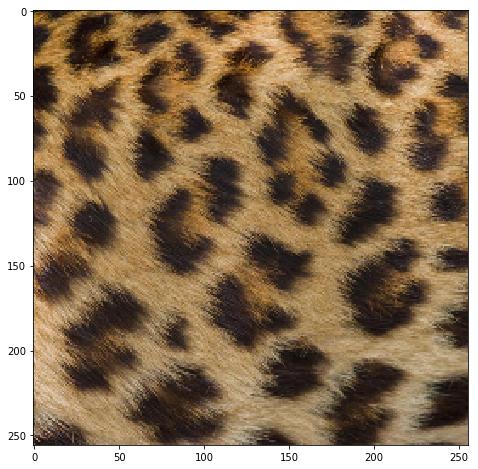

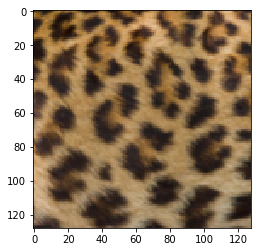

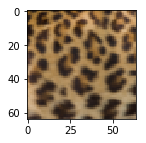

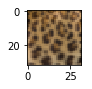

/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


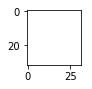

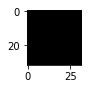

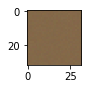

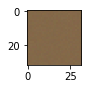


source
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 0s
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 0s
start gram
gram done
start histogram
histogram done
start gram loss
gram loss done
start histogram loss
hist loss done
start total variation loss
total variation loss done
minimizing
1 2 3 4 5 6 7 8 9 10 
Loss evaluation # 10 , loss: 2.28047e+09


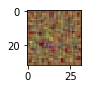

11 12 13 14 15 16 17 18 19 20 
Loss evaluation # 20 , loss: 7.50537e+08


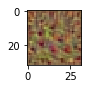

21 22 23 24 25 26 27 28 29 30 
Loss evaluation # 30 , loss: 4.02857e+08


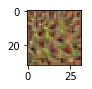

31 32 33 34 35 36 37 38 39 40 
Loss evaluation # 40 , loss: 2.64237e+08


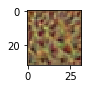

41 42 43 44 45 46 47 48 49 50 
Loss evaluation # 50 , loss: 2.16049e+08


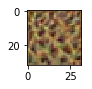

51 INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: 184227200.000000
  Number of iterations: 45
  Number of functions evaluations: 51
minimized
Task took 30.31 seconds, 0.61 seconds/iteration


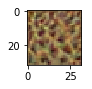

reset graph

initialize



/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


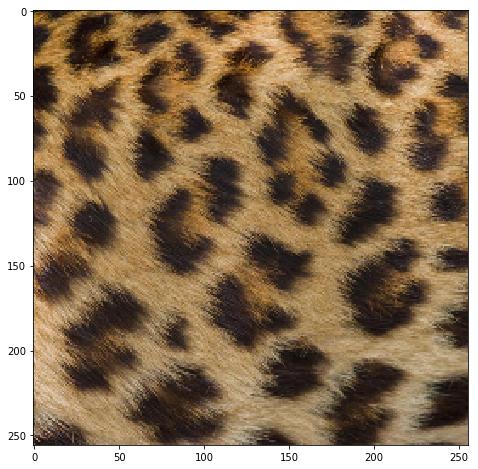

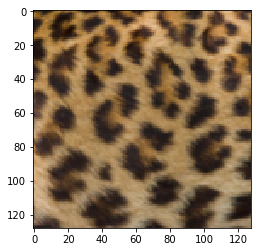

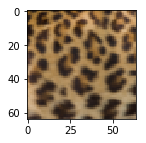

/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


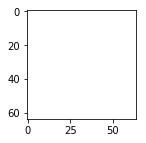

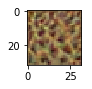

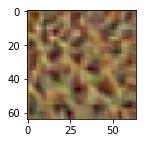


source
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 0s
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 0s
start gram
gram done
start histogram
histogram done
start gram loss
gram loss done
start histogram loss
hist loss done
start total variation loss
total variation loss done
minimizing
1 2 3 4 5 6 7 8 9 10 
Loss evaluation # 10 , loss: 1.06778e+09


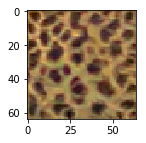

11 12 13 14 15 16 17 18 19 20 
Loss evaluation # 20 , loss: 3.84402e+08


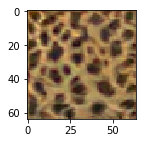

21 22 23 24 25 26 27 28 29 30 
Loss evaluation # 30 , loss: 2.49918e+08


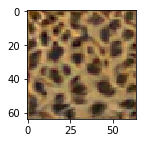

31 32 33 34 35 36 37 38 39 40 
Loss evaluation # 40 , loss: 2.0421e+08


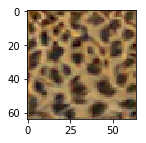

41 42 43 44 45 46 47 48 49 50 
Loss evaluation # 50 , loss: 1.78142e+08


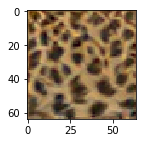

51 INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: 176167424.000000
  Number of iterations: 48
  Number of functions evaluations: 51
minimized
Task took 37.18 seconds, 0.74 seconds/iteration


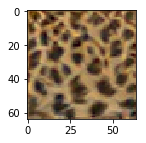

reset graph

initialize



/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


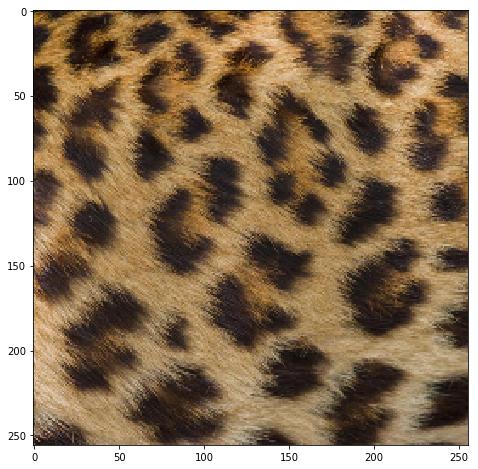

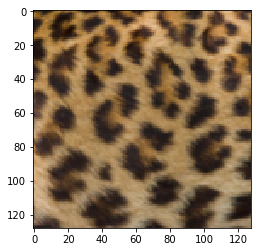

/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


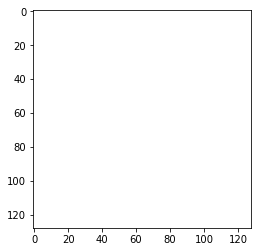

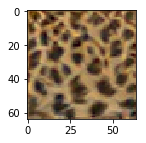

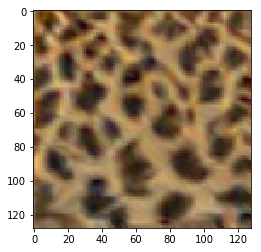


source
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 0s
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 0s
start gram
gram done
start histogram
histogram done
start gram loss
gram loss done
start histogram loss
hist loss done
start total variation loss
total variation loss done
minimizing
1 2 3 4 5 6 7 8 9 10 
Loss evaluation # 10 , loss: 7.59847e+08


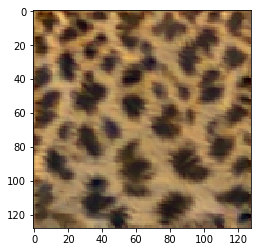

11 12 13 14 15 16 17 18 19 20 
Loss evaluation # 20 , loss: 5.57326e+08


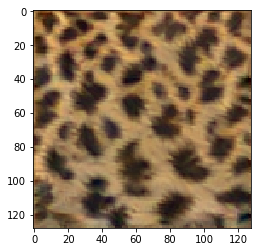

21 22 23 24 25 26 27 28 29 30 
Loss evaluation # 30 , loss: 5.01023e+08


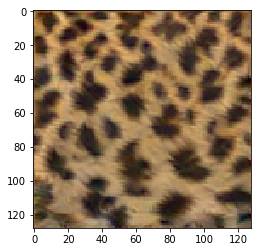

31 32 33 34 35 36 37 38 39 40 
Loss evaluation # 40 , loss: 4.80818e+08


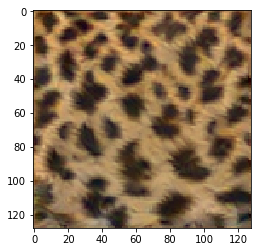

41 42 43 44 45 46 47 48 49 50 
Loss evaluation # 50 , loss: 4.65697e+08


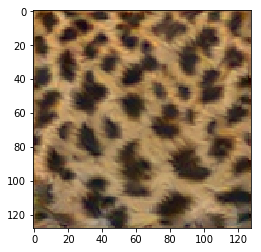

51 INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: 465005024.000000
  Number of iterations: 46
  Number of functions evaluations: 51
minimized
Task took 66.86 seconds, 1.34 seconds/iteration


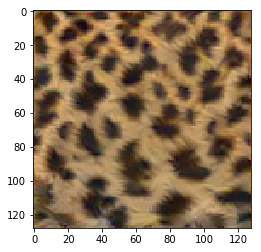

reset graph

initialize



/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


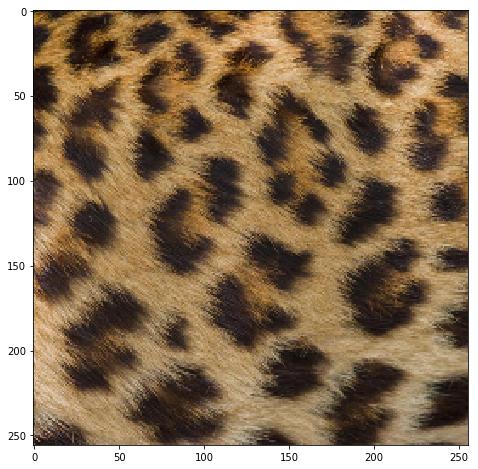

/Users/laurens/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


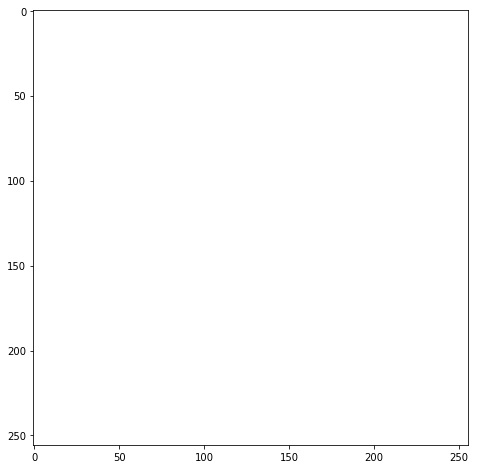

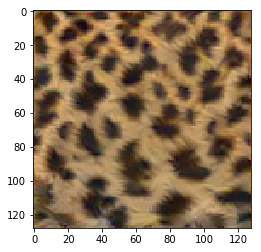

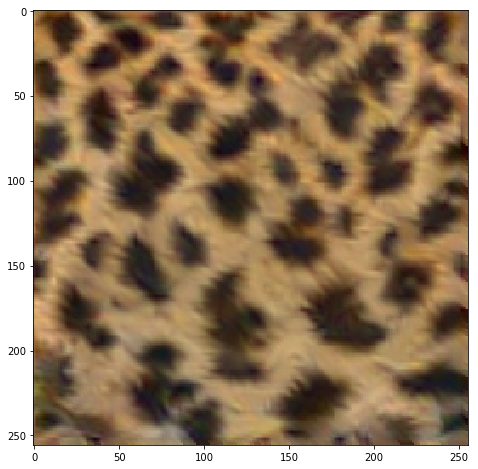


source
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 0s
/Users/laurens/in4015_2/vgg19.npy
npy file loaded
build model started
build model finished: 1s
start gram
gram done
start histogram
histogram done
start gram loss
gram loss done
start histogram loss
hist loss done
start total variation loss
total variation loss done
minimizing
1 2 3 4 5 6 7 8 9 10 
Loss evaluation # 10 , loss: 1.50273e+09


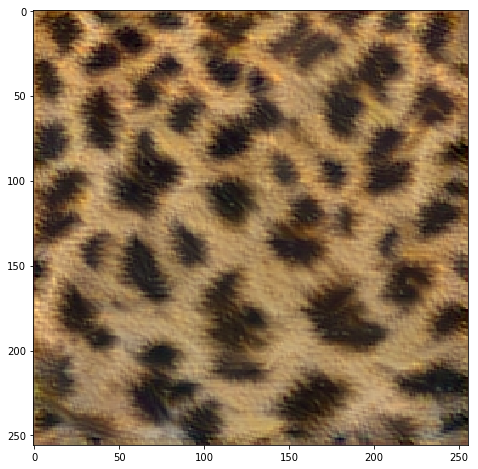

11 12 13 14 15 16 17 18 19 20 
Loss evaluation # 20 , loss: 1.38528e+09


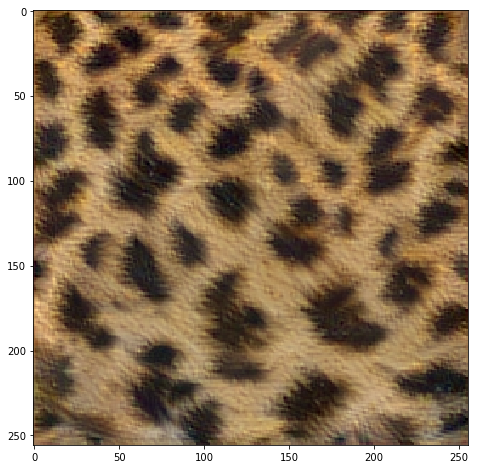

21 22 23 24 25 26 27 28 29 30 
Loss evaluation # 30 , loss: 1.36064e+09


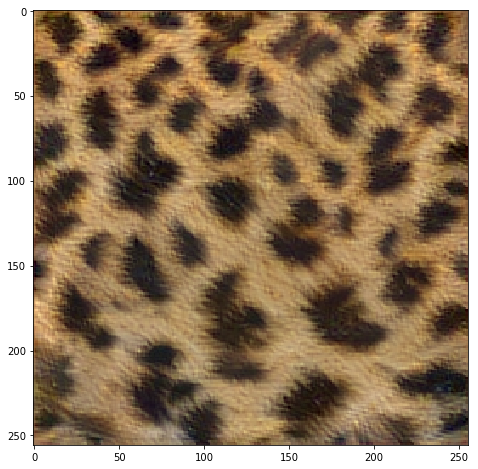

31 32 33 34 35 36 37 38 39 40 
Loss evaluation # 40 , loss: 1.35311e+09


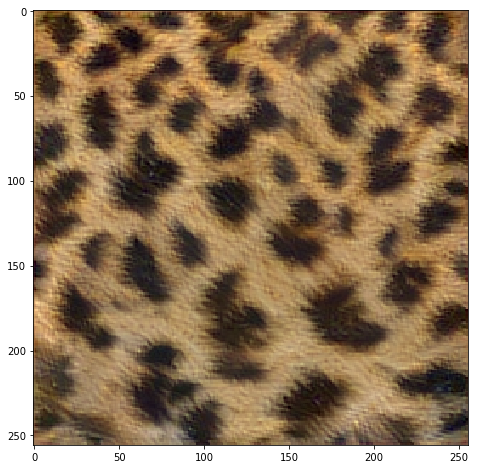

41 42 43 44 45 46 47 48 49 50 
Loss evaluation # 50 , loss: 1.34802e+09


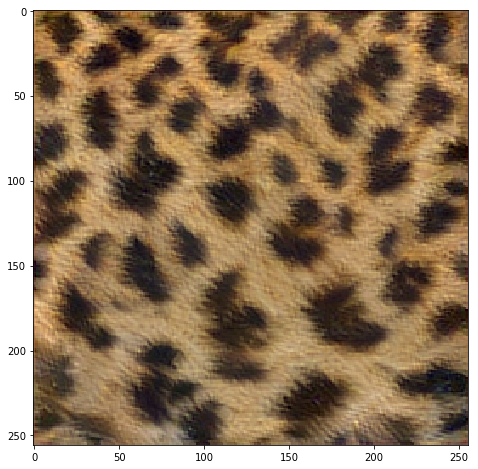

51 INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
  Objective function value: 1347554176.000000
  Number of iterations: 47
  Number of functions evaluations: 51
minimized
Task took 184.58 seconds, 3.69 seconds/iteration


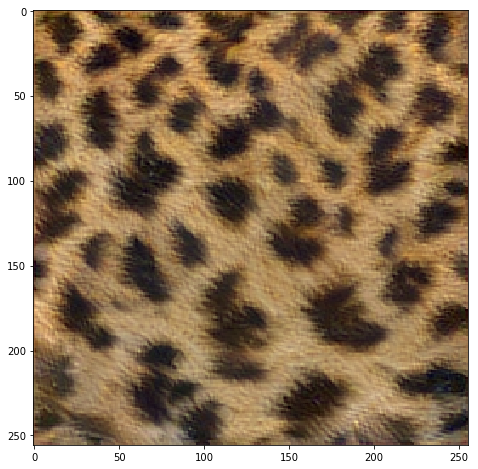

In [22]:
with tf.device(device):    
    source_old = np.zeros((1,size,size,1));
    
    for pyramid_layer in range(pyramid_height,0,-1):
    
        print('reset graph\n')
        tf.reset_default_graph()        
    
        print('initialize\n')        
        sess = tf.Session()
        loss = 0
        cur_size = round(size/(2**(pyramid_layer - 1)))
    
        [input_images, input_masks, source_init] = init_images(pyramid_layer, source_old)
        source = tf.Variable(source_init, tf.float32)
    
        for input_mask, input_image in zip(input_masks, input_images):
            style_image = tf.constant(input_image, tf.float32)
            style_mask = tf.constant(input_mask, tf.float32)

            print('\nsource')
            vgg = vgg19.Vgg19()
            vgg.build(source)

            source_gram_layers = masked_layers(style_mask, [vgg.conv1_2, vgg.conv2_2, vgg.conv3_3, vgg.conv4_3, vgg.conv5_3])
            source_hist_layers = masked_layers(style_mask, [source, vgg.conv1_1, vgg.conv4_1])
            source_tv_layers = masked_layers(style_mask, [source, vgg.conv1_1])

            [style_gram_matrices, style_cdfs] = get_style_data(style_image, style_mask)

            #get source gram matrices per layer
            print('start gram loss')
            source_layer_gram = get_gram_matrices(source_gram_layers)
            loss += gram_weight * get_gram_loss(source_layer_gram, style_gram_matrices, gram_layer_weight)
            print('gram loss done')

            #get source histogram
            print('start histogram loss')
            loss += hist_weight * get_histogram_loss(source_hist_layers, style_cdfs, hist_layer_weight, hist_grouping, hist_range, hist_bins)
            print('hist loss done')

            #get total variation loss
            print('start total variation loss')
            loss += tv_weight * get_tv_loss(source_tv_layers, tv_layer_weight)
            print('total variation loss done')
            
        i=1
        def callback(loss,source, cur_size):
            global i
            source = tf.minimum(tf.maximum(source,0.0),1)

            if (optimizer_plot == True):
                wall_time = time.time() - start_time


            print(i, end = '')
            print(' ', end = '')

            if((i) % i_print == 0):

                #print loss
                print('')
                # loss_compute = sess.run(loss)
                print('Loss evaluation #', i, ', loss:', loss)

                if (optimizer_plot == True):
                    loss_graph.append((wall_time, loss))

                #show image
                if(show == True):
                    fig = plt.figure(figsize=(cur_size/32,cur_size/32))
                    plt.imshow(sess.run(tf.reshape(source,(cur_size,cur_size,3))))
                    plt.show()
                    #fig.savefig('final/%d_final.png' % i)

            i += 1
            
        #L-BFGS-B Optimizer not honoring maximum iterations given
        # see https://github.com/scipy/scipy/issues/3334
        optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss,method='L-BFGS-B',options={'maxfun': i_max})

        sess.run(tf.global_variables_initializer())
        print("minimizing")

        if (optimizer_plot == True):
            start_time = time.time()

        try:
            optimizer.minimize(sess,fetches =[tf.reduce_sum(loss), source, tf.constant(cur_size)], loss_callback=callback)

        # Just proceed happily if user interrupts program
        except KeyboardInterrupt:
            pass

        if (optimizer_plot == True):
            wall_time = time.time() - start_time
        print("minimized")
        print ('Task took {:.2f} seconds, {:.2f} seconds/iteration'.format(wall_time, wall_time/i_max))  

        # print(sess.run(loss, feed_dict = feed))
        # print(sess.run(get_loss(target_layers, style_layers), feed_dict = feed))

        source = tf.minimum(tf.maximum(source,0.0),1)
        source_old = sess.run(tf.minimum(tf.maximum(source,0.0),1))
        #show image
        if(show == True):
            plt.figure(figsize=(cur_size/32,cur_size/32))
            plt.imshow(sess.run(tf.reshape(source,(cur_size,cur_size,3))))
            plt.show()   

(6.304970026016235, 11.769190073013306, 17.223271131515503, 22.86016607284546, 28.606325149536133, 7.947728872299194, 15.486063241958618, 22.284630060195923, 28.697368144989014, 35.84990906715393, 12.442158937454224, 23.246543884277344, 36.768043756484985, 51.789361000061035, 64.14404582977295, 41.111855030059814, 77.57143712043762, 114.23411297798157, 147.2002739906311, 180.3562400341034) (2.2804739e+09, 7.5053747e+08, 4.0285741e+08, 2.6423694e+08, 2.1604894e+08, 1.067784e+09, 3.8440246e+08, 2.4991821e+08, 2.0421016e+08, 1.7814192e+08, 7.5984672e+08, 5.5732621e+08, 5.0102253e+08, 4.8081837e+08, 4.6569738e+08, 1.5027338e+09, 1.3852768e+09, 1.3606399e+09, 1.3531099e+09, 1.3480209e+09)


AttributeError: 'list' object has no attribute 'xlabel'

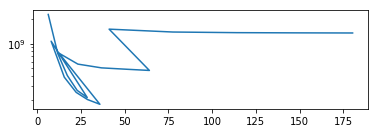

In [23]:
# Plot the loss over time
# loss_graph = np.asarray(loss_graph)
fig = plt.figure()
# print(zip(*loss_graph))
# losses_zipped = zip(*loss_graph)
print(*zip(*loss_graph))
ax = fig.add_subplot(2,1,1)
plot = ax.plot(*zip(*loss_graph))
ax.set_yscale('log')
# plot = plt.plot(loss_graph[:, 0], loss_graph[:, 1])
plot.xlabel('Wall time (seconds)', fontsize=12)
plot.ylabel('Loss', fontsize=12)
# plt.ylim([90, 250])
# fig.savefig('{}-{}.pdf'.format() #TODO: save image